# シナリオ案

- 問題：分析実装後のアラームの再設定検討や仕組みを理解するための時間が増え作業負荷が増大したように感じる
- 課題：アラームに対して次のアプローチを考えることが(時間がかかったり技術が無く)難しい

- 事前に入力として現在設定している閾値を持っていることとする。

- アラーム発生からそれ以前のデータを収集し、データ分布や時系列での状況を可視化+GPTでデータの概要を生成する。(○○に発生したアラームではHTTPステータス○○のエラーが発生し、処理が正常終了しなかったためアラームが発生しました。このアラームの直前には○○が起きており、このアラームより前のデータ○○個のデータをみると...)
- アラーム発生からそれ以前のデータを使い簡易的な分析を実施、新しい閾値の提案とその場合データはどのように読み取ることができるようになるのかを現状と比較しての概要説明をGPTモデルで生成する
    - 閾値設定用の分析は、取得データの分布95%のデータを正常とし、5%を異常とする形でHold Out法で教師なしで分析を実施する。時系列を考慮したARIMAでの分析もしたいな

あたかもGPTモデルがデータの説明・可視化、閾値の再設定案の提示まで自動でやってくれる感じにしたい<br>
入出力のあいまいさを許しつつ出力の曖昧さはルールで補う漢字で

- アラームに対して次のアプローチを提示するためアラーム発報時のデータの重要度の高いトークンをいくつか抽出(HTTPステータスが抽出されるイメージ)し、ReActでDBまたはネットからトークンに関連する情報をもとに次のアプローチを生成する

In [1]:
from contextlib import contextmanager
from time import time

class Timer:
    """処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)

    with Timer(prefix='fit fold={} '.format(i), verbose=500):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [2]:
import gc
gc.collect()

257

In [3]:
# アラーム前まで仮定で設定している閾値(現在設定中の閾値)
threshold = 1000

## 疑似データの作成

In [4]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

def seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
seed(42)

# データ件数と異常値の数を10:1になるように設定
data_size = 1000
num_anomalies = 100

# 日付インデックスを生成
date_rng = pd.date_range(start='2021-01-01', end='2021-12-31', freq='S')
date_rng = np.random.choice(date_rng, data_size, replace=False)
date_rng.sort()

# レスポンスタイムの正規分布に従ったランダムデータを生成
response_time_data = np.random.normal(loc=200, scale=20, size=data_size)

# ステータスコードのリストを作成
status_codes = ['200', '201', '204', '400', '401', '403', '404', '500', '502', '503']
status_code_probs = [0.6, 0.1, 0.05, 0.1, 0.02, 0.02, 0.08, 0.01, 0.01, 0.01]
status_code_data = np.random.choice(status_codes, size=data_size, p=status_code_probs)

# 異常値をランダムに挿入
anomaly_indices = random.sample(range(data_size), num_anomalies)
for idx in anomaly_indices:
    response_time_data[idx] = np.random.normal(loc=1000, scale=100)
    status_code_data[idx] = random.choice(['404', '500', '502', '503'])

# データフレームを作成
# df = pd.DataFrame(data={'response_time': response_time_data, 'status_code': status_code_data}, index=date_rng)
df = pd.DataFrame(data={'date_time': date_rng, 'response_time': response_time_data, 'status_code': status_code_data})


In [5]:
df.head()

,date_time,response_time,status_code
0,2021-01-01 01:13:30,235.196490,201
1,2021-01-01 14:29:43,216.519988,200
2,2021-01-02 03:15:21,188.627762,200
3,2021-01-02 10:17:39,181.143408,200
4,2021-01-02 16:28:55,189.266348,400


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

def plot_count(feature, title, df, size=1):
    """クラス/特徴量をプロットする
    Pram:
        feature : 分析するカラム
        title : グラフタイトル
        df : プロットするデータフレーム
        size : デフォルト 1.
    """
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    # 最大20カラムをヒストグラムで表示
#     g = sns.countplot(data=df, x = feature, order = df[feature].value_counts().index[:20], palette='Set3')
    g = sns.countplot(data=df, y = feature, order = df[feature].value_counts().index[:10], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
#     if(size > 2):
        # サイズ2以上の時、行名を90°回転し、表示
#         plt.xticks(rotation=90, size=8)
    # データ比率の表示
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
#         ax.text(p.get_x()+p.get_width()/2.,
#                 height + 3,
#                 '{:1.2f}%'.format(100*height/total),
#                 ha="center")
        ax.text(width + 40,
                p.get_y()+p.get_height()+.025/2.,
                '{:1.2f}%'.format(100*width/total),
                ha="right") 
    plt.tight_layout()
    plt.show()

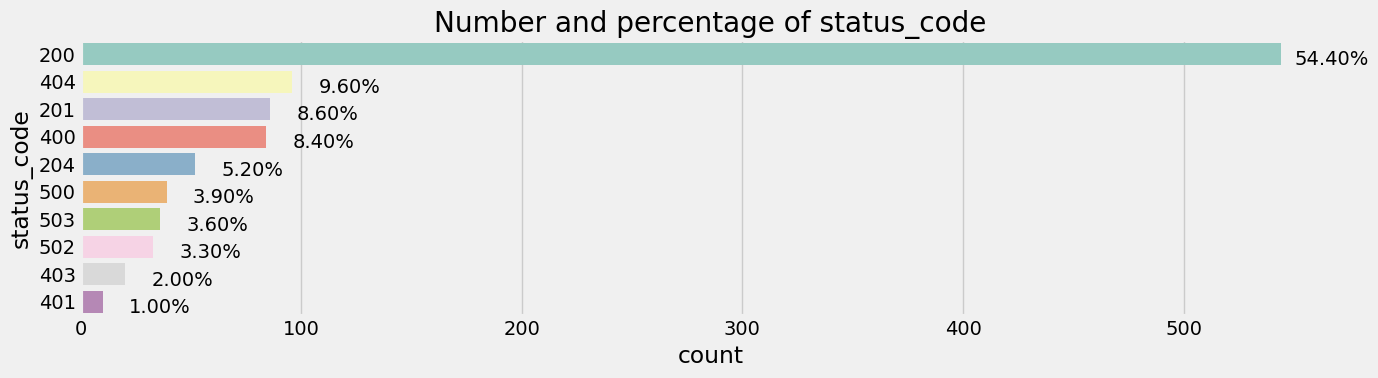

In [7]:
# 全データのstatus_codeの比率を確認する
plot_count(feature='status_code', title='status_code', df=df, size=3.5)

In [8]:
df['status_code'].value_counts()

status_code
200    544
404     96
201     86
400     84
204     52
500     39
503     36
502     33
403     20
401     10
Name: count, dtype: int64

In [9]:
print(f'Number of all data: {df.shape[0]}')

Number of all data: 1000


In [10]:
import matplotlib.dates as mdates

# 時系列可視化
def time_prot(df, threshold=0, lebel_name='threshold', color='darkblue', title='Response Time Time Series'):
    fig, ax = plt.subplots(1,1, figsize=(4*3.2,4))
    ax.plot(df['date_time'], df['response_time'], marker='o', color='lightskyblue')


    # response_timeが800以上のデータのstatus_codeを表示
    for index, row in df.iterrows():
        if threshold != 0:
            if row['response_time'] >= threshold:
                # ax.text(row['date_time'], row['response_time'], str(row['status_code']), backgroundcolor="lightyellow")
                ax.text(row['date_time'], row['response_time'], str(row['status_code']), size=8)

    # x軸の設定
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # 閾値の表示
    if threshold != 0:
        ax.axhline(y=threshold, c=color, linewidth = 1.6, alpha=0.64, label=lebel_name)
        # 凡例の設定
        # ax.legend(loc='upper left')
        ax.legend()

    # タイトルとラベルの設定
    plt.title(title)
    plt.xlabel('Date Time')
    plt.ylabel('Response Time')
    plt.tight_layout()
    plt.show()

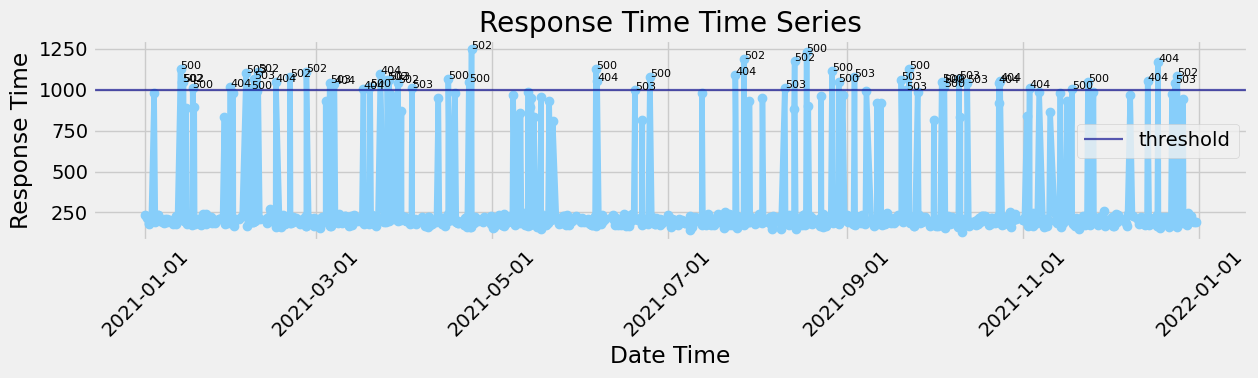

In [11]:
time_prot(df, threshold)

In [12]:
df[df['response_time'] >= threshold]

,date_time,response_time,status_code
25,2021-01-13 05:21:11,1124.366513,500
27,2021-01-13 15:37:20,1045.896602,502
30,2021-01-14 04:53:20,1049.931362,502
44,2021-01-17 09:57:30,1011.391710,500
80,2021-01-30 08:08:47,1016.802237,404
89,2021-02-04 21:53:57,1104.939942,503
95,2021-02-06 18:43:58,1003.455028,500
99,2021-02-07 16:04:52,1068.312356,503
104,2021-02-09 01:14:46,1107.179114,502
114,2021-02-15 05:49:43,1048.247816,404


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

def res_plot_count(feature, title, df, size=1):
    """クラス/特徴量をプロットする
    Pram:
        feature : 分析するカラム
        title : グラフタイトル
        df : プロットするデータフレーム
        size : デフォルト 1.
    """
    f, ax = plt.subplots(1,1, figsize=(32*size,4))
    total = float(len(df))
    # 最大20カラムをヒストグラムで表示
#     g = sns.countplot(data=df, x = feature, order = df[feature].value_counts().index[:20], palette='Set3')
    g = sns.countplot(data=df, y = feature, order = df[feature].value_counts().index[:10], palette='Set3')
    g.set_title("Setting Anomaly Data\nNumber and percentage of {}".format(title), size=16)
#     if(size > 2):
        # サイズ2以上の時、行名を90°回転し、表示
#         plt.xticks(rotation=90, size=8)
    # データ比率の表示
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
#         ax.text(p.get_x()+p.get_width()/2.,
#                 height + 3,
#                 '{:1.2f}%'.format(100*height/total),
#                 ha="center")
        ax.text(width + 0.36,
                p.get_y()+p.get_height()+.025/2.,
                f'Number of data: {width}\nRatio: '+'{:1.2f}%'.format(100*width/total),
                ha="right") 
    plt.tight_layout()
    plt.show()

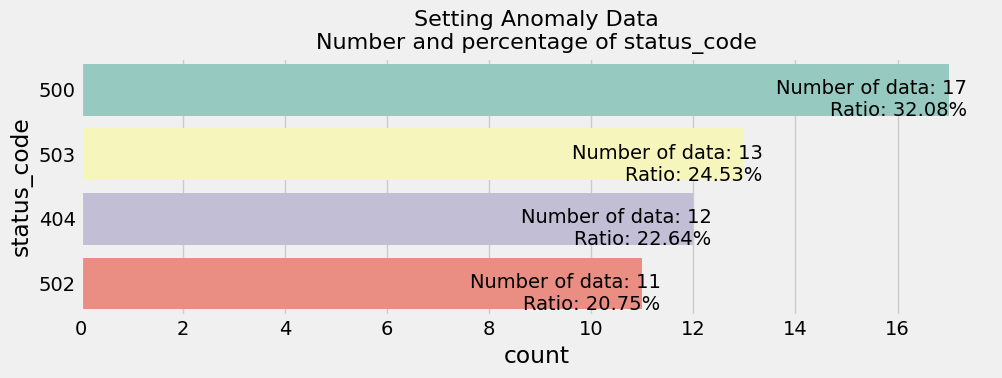

In [14]:
# response_time=1000を異常と分類した時の異常データのstatus_codeの比率を確認する
res_plot_count(feature='status_code', title='status_code', df=df[df['response_time'] >= threshold], size=0.32)

In [15]:
df[df['response_time'] >= threshold]['status_code'].value_counts()

status_code
500    17
503    13
404    12
502    11
Name: count, dtype: int64

In [16]:
anomaly_num = df[df['response_time'] >= threshold].shape[0]
print(f'Number of Anomaly data: {anomaly_num}')

Number of Anomaly data: 53


# 簡易分析の実施

## 分析の前に目的変数の正規性の確認

In [17]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.stats import norm

In [18]:
def plot_dist3(df, feature, title):
    """
    カラムが連続値用の可視化関数
    """
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(16, 9)
    # 3列、3行のグリッドを作成します
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    # ヒストグラムの図示    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    # seaborn v0.14.0 removed
    # Please adapt your code to use either `displot` 
    # (a figure-level function with similar flexibility) or 
    # `histplot` (an axes-level function for histograms).
    # sns.distplot(df.loc[:, feature],
    #              hist=True,
    #              kde=True,
    #              fit=norm,
    #               hist_kws={
    #              'rwidth': 0.85,
    #              'edgecolor': 'black',
    #              'alpha': 0.8},
    #              ax=ax1,
    #              color='darkorange')

    sns.histplot(df.loc[:, feature],
                 kde=True,
                 hue_order =(0, 1),
                 bins=30,
                 color='darkorange',
                 ax=ax1,)

    ax1.axvline(df.loc[:, feature].mean(), color='darkblue', linestyle='dashed', linewidth=3)
    min_ylim, max_ylim = plt.ylim()
    # 平均値の表示
    # ax1.text(df.loc[:, feature].mean()*1.95, max_ylim*0.95, 'Mean: {:.2f}'.format(df.loc[:, feature].mean()), color='Black', fontsize='12',
    #          bbox=dict(boxstyle='round',facecolor='darkorange', alpha=0.5))
    ax1.legend(labels=['Actual','Normal'])
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=24))

    # QQプロット
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=24))

    # Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(y=feature, data=df, ax=ax3, palette='Set3')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)

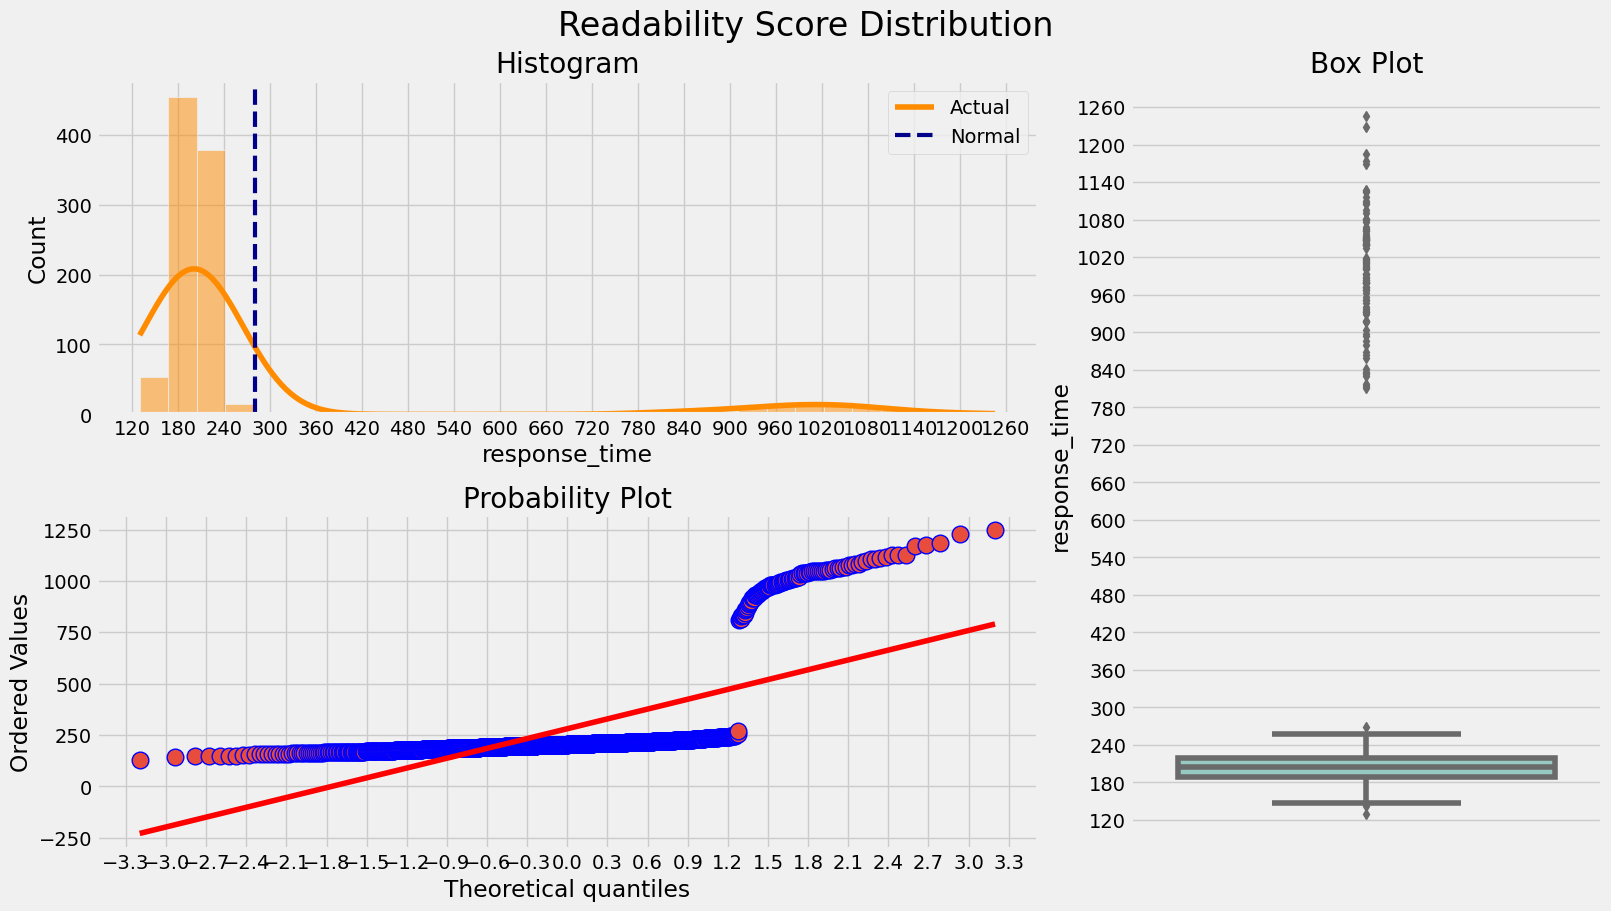

In [19]:
# 全データでの正規性の確認
plot_dist3(df, 'response_time', 'Readability Score Distribution')

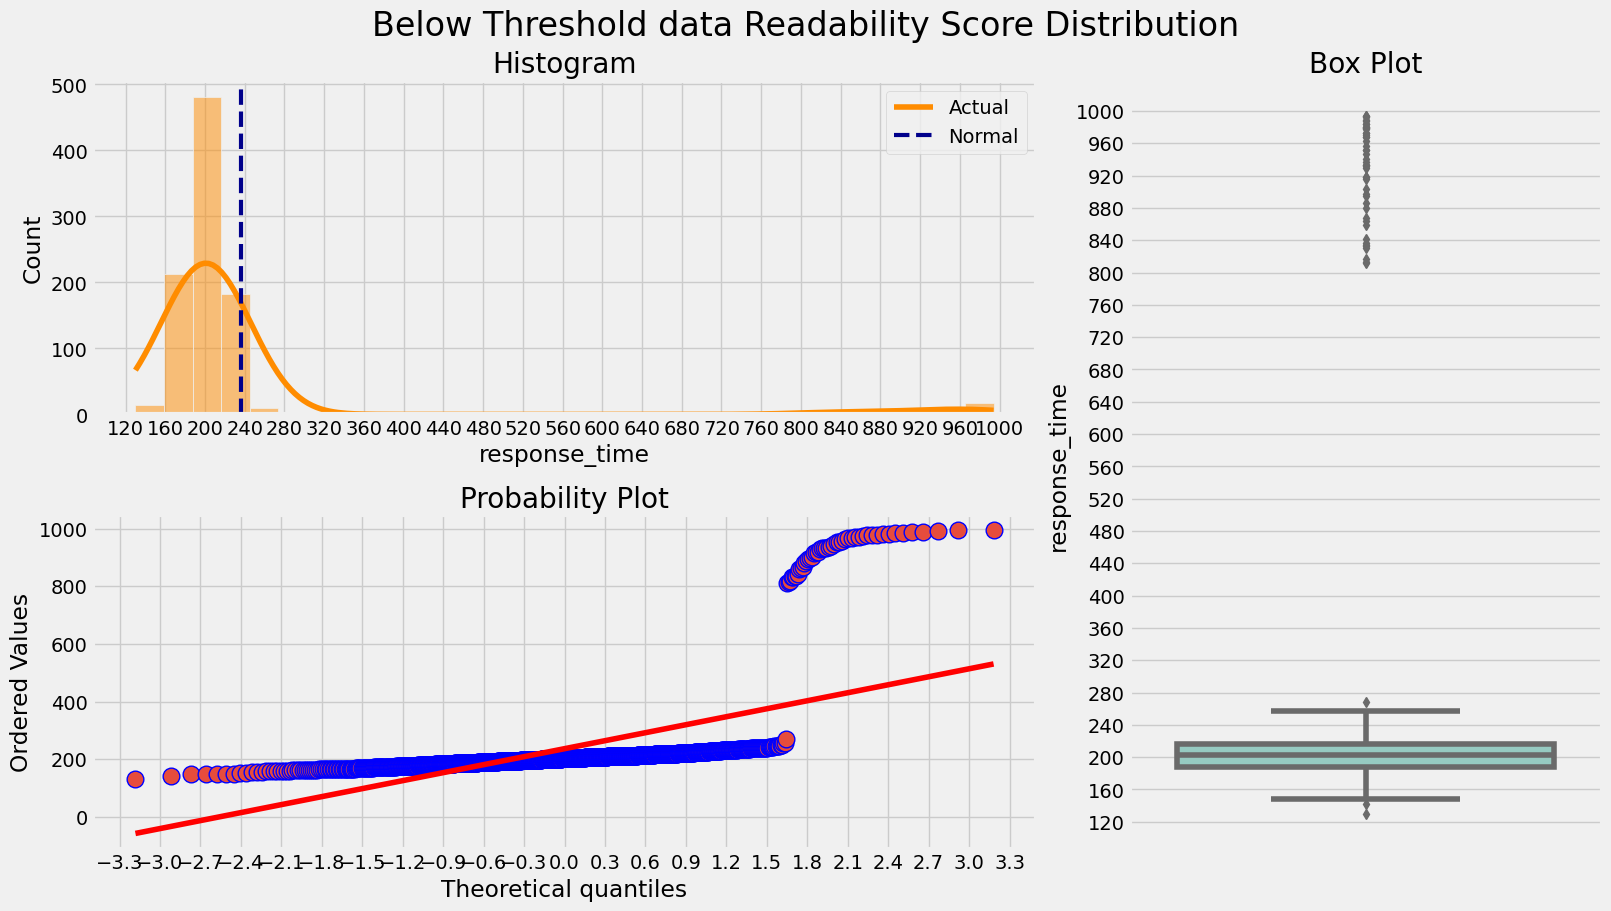

In [20]:
# 仮定で設定している現閾値以下のデータで正規性を確認
plot_dist3(df[df['response_time'] < threshold], 'response_time', 'Below Threshold data Readability Score Distribution')

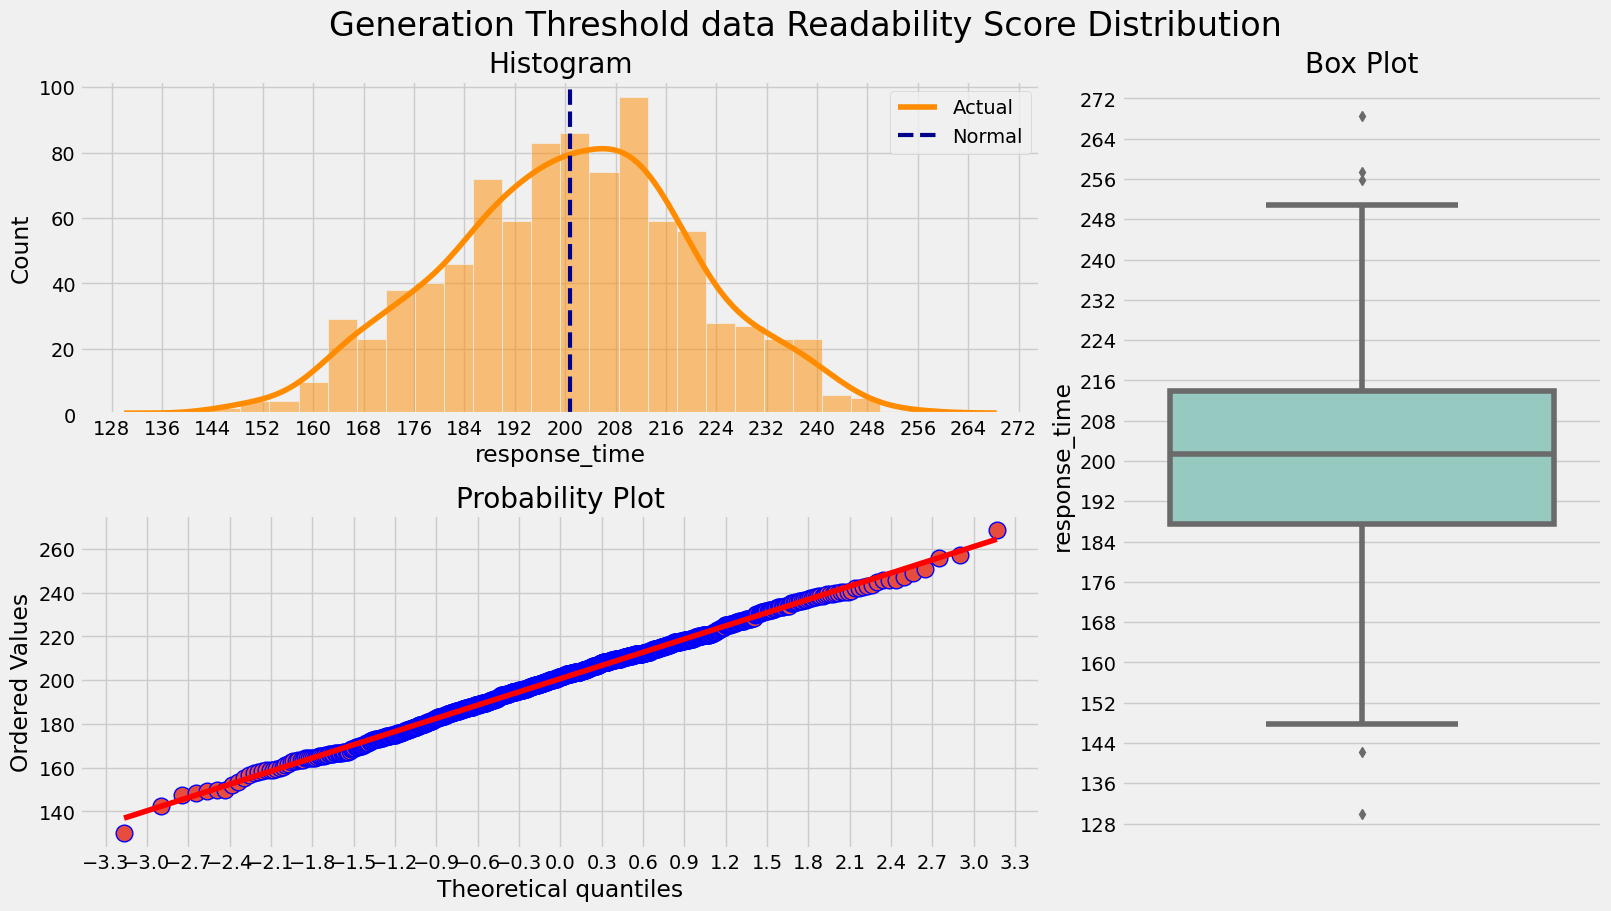

In [21]:
# データ生成時に外れ値として設定した800以下のデータで正規性確認
plot_dist3(df[df['response_time'] < 800], 'response_time', 'Generation Threshold data Readability Score Distribution')

## 欠損値の確認

In [22]:
# 欠損値計算関数
def missing_value_table(df):
    """欠損値の数とカラムごとの割合の取得
    Param : DataFrame
    確認を行うデータフレーム
    """
    # 欠損値の合計
    mis_val = df.isnull().sum()
    # カラムごとの欠損値の割合
    mis_val_percent = 100 * mis_val / len(df)
    # 欠損値の合計と割合をテーブルに結合
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # カラム名の編集
    mis_val_table = mis_val_table.rename(
        columns={0:'Missing Values', 1:'% of Total Values'}
    )
    # データを欠損値のあるものだけにし。小数点以下1桁表示で降順ソートする
    mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False
    ).round(1)

    # 欠損値をもつカラム数の表示
    print('このデータフレームのカラム数は、', df.shape[1])
    print('このデータフレームの欠損値列数は、', mis_val_table.shape[0])
    # 欠損値データフレームを返す
    return mis_val_table

In [23]:
missing_value_table(df)

このデータフレームのカラム数は、 3
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


In [24]:
# 欠損値はないが一応除外処理
df.dropna(how='all', inplace=True)

## 学習用データを作成

四分位範囲外のデータを異常値と仮定して除外して、その半分を学習に使用する

In [25]:
def remove_outlier(df_in, col_name):
    """
    カラムデータの四分位範囲外の除外
    Parametr:
        df_in:
            対象のデータフレーム
        col_name:
            対象のデータフレームカラム名
    Return:
        四分位範囲外を除外したカラムデータ
    """
    # 四分位範囲の算出
    q1 = df_in[col_name].quantile(0.25)     # 第一四分位数 25%パーセンタイル
    q3 = df_in[col_name].quantile(0.75)     # 第三四分位数 75%パーセンタイル
    iqr = q3-q1                             # 四分位範囲
    # 外れ値に当たる範囲を算出
    fence_low  = q1 - 1.5*iqr               # 第一四分位数-第四四分位数
    fence_high = q3 + 1.5*iqr               # 第三四分位数-第四四分位数
    
    # return fence_low, fence_high
    # 範囲外の除外
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    df_in = df_in.loc[(df_in[col_name] <= fence_low) | (df_in[col_name] >= fence_high)]
    return df_out, df_in

In [26]:
# 四分位範囲外のデータの除外
df_out, df_in = remove_outlier(df, 'response_time')
df_out.reset_index(inplace=True, drop=True)

# 除外結果
df.shape, df_out.shape, df_in.shape

((1000, 3), (897, 3), (103, 3))

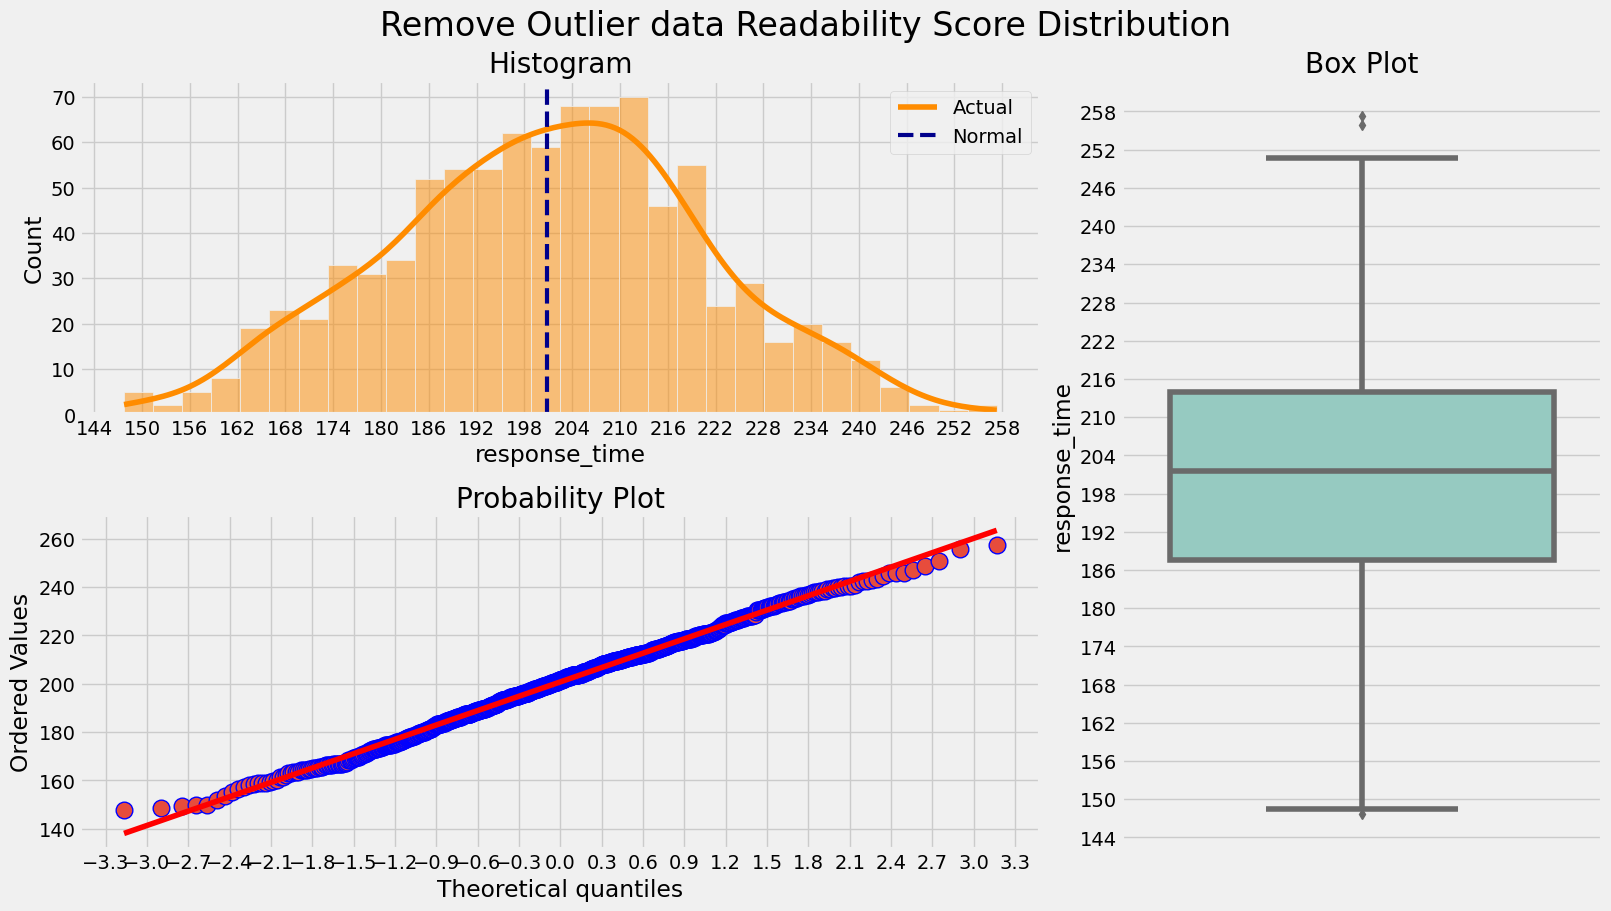

In [27]:
plot_dist3(df_out, 'response_time', 'Remove Outlier data Readability Score Distribution')

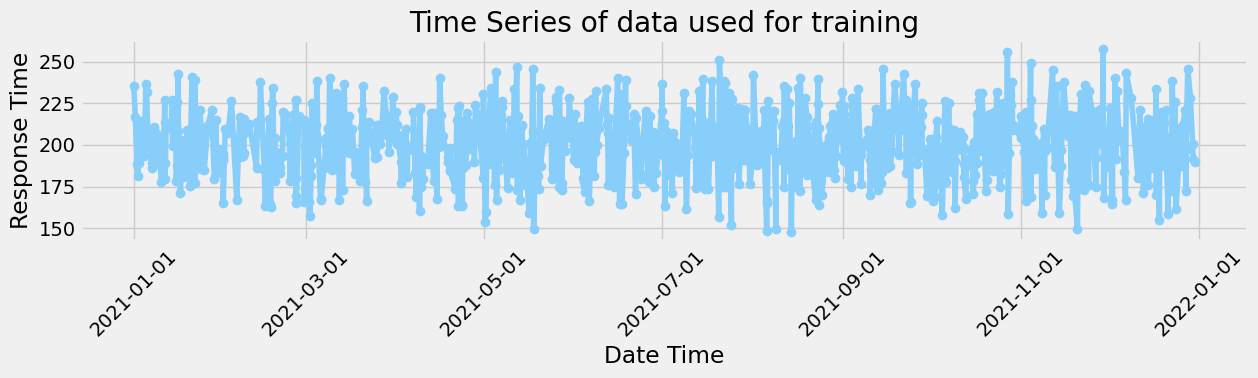

In [28]:
time_prot(df_out, title='Time Series of data used for training')

In [29]:
# dfの行数を取得し、半分を計算する
half_len = len(df_out) // 2

# 最初の半分の行を抽出する
train_df = df_out.iloc[:half_len]
train_df.reset_index(inplace=True, drop=True)

In [30]:
valid_df = pd.concat([df_out.iloc[half_len:], df_in])
valid_df = valid_df.sort_values('date_time')

valid_df.reset_index(inplace=True, drop=True)

In [31]:
train_df.shape, valid_df.shape

((448, 3), (552, 3))

## LOFによる簡易分析の実行

In [32]:
from sklearn.neighbors import LocalOutlierFactor

In [33]:
# 近傍数を設定してLOFをインスタンス化
lof = LocalOutlierFactor(n_neighbors=8, novelty=True, contamination='auto')
lof.fit(train_df.drop(['date_time', 'status_code'], axis=1))

LocalOutlierFactor(n_neighbors=8, novelty=True)

In [34]:
pred = lof._predict(valid_df.drop(['date_time', 'status_code'], axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [35]:
# lof_grids = lof.decision_function(valid_df.drop(['date_time', 'status_code'], axis=1))
# lof_grids = lof_grids.reshape(xx.shape)
# lof_grids

In [36]:
valid_df['judgment'] = pred

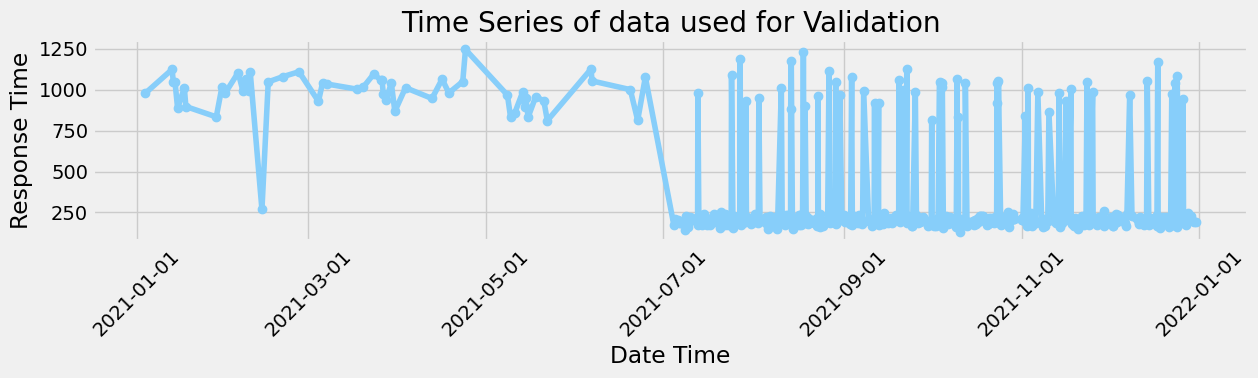

In [37]:
time_prot(valid_df, title='Time Series of data used for Validation')

In [38]:
valid_df['judgment'].value_counts()

judgment
 1    401
-1    151
Name: count, dtype: int64

## 新しい閾値の設定と可視化

In [39]:
# 異常と予測したデータを閾値設定用データとして取得
pred_anomaly_df = valid_df[valid_df['judgment']==-1].copy()
pred_anomaly_df.reset_index(inplace=True, drop=True)

In [40]:
pred_anomaly_df['judgment'].value_counts()

judgment
-1    151
Name: count, dtype: int64

In [41]:
# 500と503に対して重みを設定した加重平均を算出し新しい閾値とする
w_500 = 1.5
w_503 = 1.2

pred_anomaly_df['weights'] = 1
pred_anomaly_df.loc[pred_anomaly_df['status_code'] == 500, 'weights'] = w_500
pred_anomaly_df.loc[pred_anomaly_df['status_code'] == 503, 'weights'] = w_503

weighted_mean = (pred_anomaly_df['response_time'] * pred_anomaly_df['weights']).sum() / pred_anomaly_df['weights'].sum()
simple_mean = pred_anomaly_df['response_time'].mean()

# 異常と分類したデータ数が少ないのもあるが結果はほぼ同じになった
print('Weighted Mean:', weighted_mean)
print('Simple Mean:  ', simple_mean)

# 新しい閾値をセット
new_threshold = weighted_mean
print('New Threshold:', new_threshold)

Weighted Mean: 727.0241094118405
Simple Mean:   727.0241094118405
New Threshold: 727.0241094118405


## 簡易分析の結果

In [42]:
# GPTが生成した文章の前に付ける文章例
print(f'四分位範囲外データを除外し、そのデータの半分である{half_len}行を学習データとして使用して、簡易的に閾値を作成しました。')

四分位範囲外データを除外し、そのデータの半分である448行を学習データとして使用して、簡易的に閾値を作成しました。


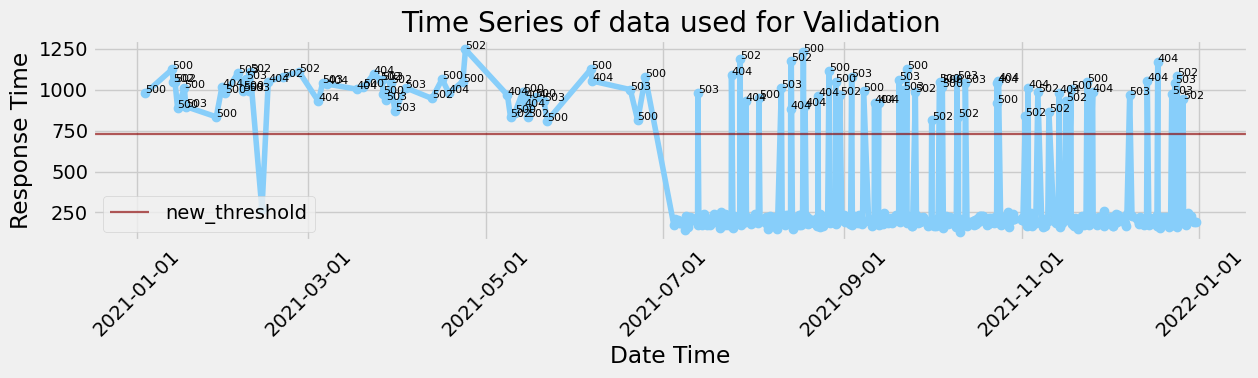

In [43]:
time_prot(valid_df, new_threshold, lebel_name='new_threshold', color='darkred', title='Time Series of data used for Validation')

In [44]:
# GPTが生成した文章の前に付ける文章例
print(f'閾値の作成はLOFによる分析を行い、異常と分類したデータの中でHTTPステータスが500または503である場合は重みを付与し加重平均を算出した結果を新しい閾値としています。\n新しい閾値:{new_threshold}\n新しい閾値を設定した場合の可視化結果は以下となります。')

閾値の作成はLOFによる分析を行い、異常と分類したデータの中でHTTPステータスが500または503である場合は重みを付与し加重平均を算出した結果を新しい閾値としています。
新しい閾値:727.0241094118405
新しい閾値を設定した場合の可視化結果は以下となります。


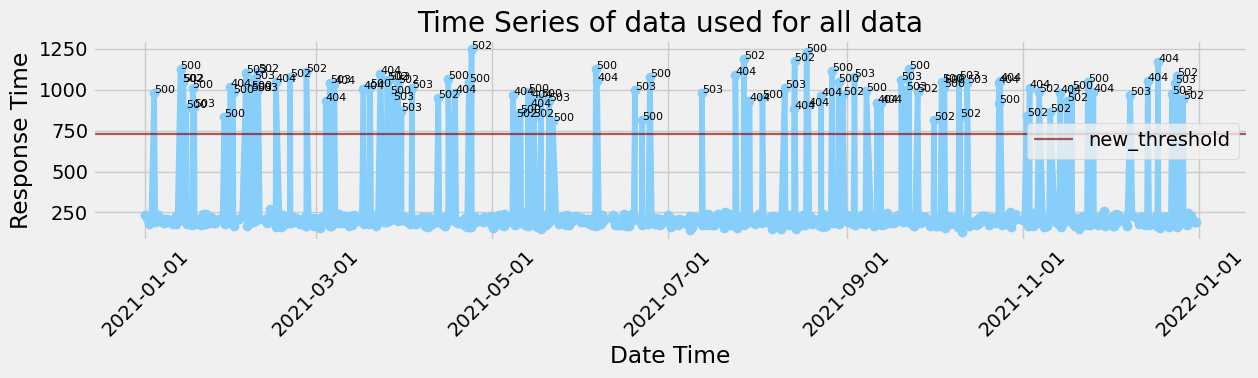

In [45]:
time_prot(df, new_threshold, lebel_name='new_threshold', color='darkred', title='Time Series of data used for all data')

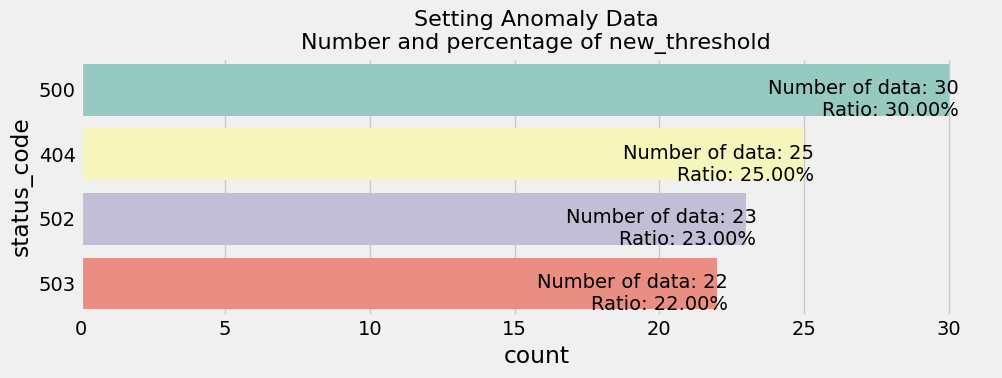

In [46]:
# 新しい閾値を異常と分類した時の異常と分類したデータのstatus_codeの比率を確認する
res_plot_count(feature='status_code', title='new_threshold', df=df[df['response_time'] >= new_threshold], size=0.32)